In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Introdução à Análise de Séries Temporais

## Load Dados

In [315]:
# Series diárias originais
ds = xr.open_dataset('singleLevel.nc')
time = ds['time']
time = pd.to_datetime(time.values)
lat = ds['latitude'].values
lon = ds['longitude'].values
mslp = ds['msl'].values  # mean sea level pressure (Pa)
mslp = mslp/100          # 100 Pa = 1 hPa
prec = ds['mtpr'].values # mean total precipitation rate (kg m**-2 s**-1 = mm/s)
prec = prec*60*60*24     # 86400  mm/s = 1 mm/dia
role = ds['ttr'].values  # top thermal radiation (toa_outgoing_longwave_flux) (J m**-2 = W s m**-2)
role = - role/(60*60*24) # 86400 W s/m**2 = 1 W dia/m**2
ds = xr.open_dataset('wind500.nc')
w500 = ds['w'].values # vento vertical em coordenadas de pressão (ômega, Pa/s)

In [310]:
# Anomalias médias no evento de ZCAS (calculadas na Aula 3)
ds2 = xr.open_dataset('zcas_27a31Out2009_anom.nc')
role_anom = ds2['role'].values

## Média Espacial

Calcular a area de cada célula de grade usando o CDO

In [12]:
%%bash
cdo gridarea singleLevel.nc area.nc

cdo gridarea: Processed 3 variables [0.08s 56MB]


In [40]:
ds = xr.open_dataset('area.nc')
area = ds['cell_area'].values*(1/1000**2) # m**2 -> km*2
ds.info()

xarray.Dataset {
dimensions:
	latitude = 281 ;
	longitude = 241 ;

variables:
	float32 longitude(longitude) ;
		longitude:standard_name = longitude ;
		longitude:long_name = longitude ;
		longitude:units = degrees_east ;
		longitude:axis = X ;
	float32 latitude(latitude) ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:units = degrees_north ;
		latitude:axis = Y ;
	float64 cell_area(latitude, longitude) ;
		cell_area:standard_name = area ;
		cell_area:long_name = area of grid cell ;
		cell_area:units = m2 ;

// global attributes:
	:CDI = Climate Data Interface version ?? (http://mpimet.mpg.de/cdi) ;
	:Conventions = CF-1.6 ;
	:history = Tue Jul 07 08:43:25 2020: cdo gridarea singleLevel.nc area.nc
2020-06-28 19:06:30 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1593371115.8512547-8693-21-af2904b8-0850-42c9-892e-db1f8c9e1fa8.nc /cache/tmp/af2904b8-0850-42c9-892e-db1f8c9e1fa8-adaptor.

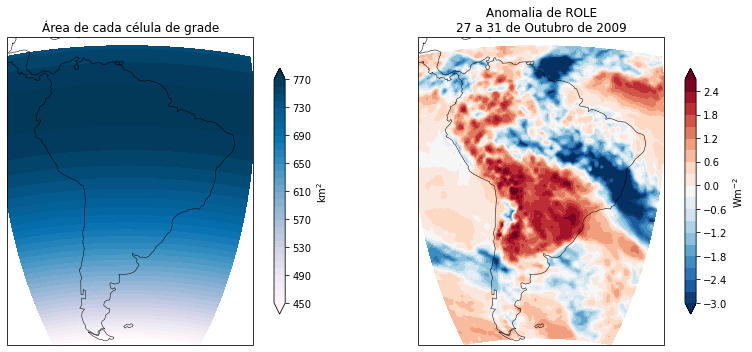

In [226]:
fig=plt.figure(figsize=(12,5))
proj=ccrs.Orthographic(central_longitude=-60, central_latitude=-20, globe=None)

ax = plt.subplot(121, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, area, extend='both', cmap = 'PuBu', transform=ccrs.PlateCarree(), 
             levels=np.arange(450,780,10))
plt.colorbar(orientation='vertical', shrink=0.8, label='km$^2$')
plt.title('Área de cada célula de grade')

ax = plt.subplot(122, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, role_anom, extend='both', cmap = 'RdBu_r', transform=ccrs.PlateCarree(),
             levels=np.arange(-3,3,0.3))
plt.colorbar(orientation='vertical', shrink=0.8, label='Wm$^{-2}$')
plt.title('Anomalia de ROLE\n27 a 31 de Outubro de 2009')

plt.tight_layout()
plt.show()

fig.savefig('AreaRole.png', dpi=300)

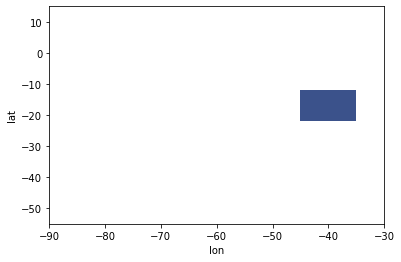

In [216]:
mask = np.ones(np.shape(role_anom))
mask[np.where((lat>-12) | (lat<-22))[0],:]=np.nan
mask[:,np.where((lon<-45) | (lon>-35))[0]]=np.nan

plt.contourf(lon,lat,mask)
plt.xlabel('lon'); plt.ylabel('lat');

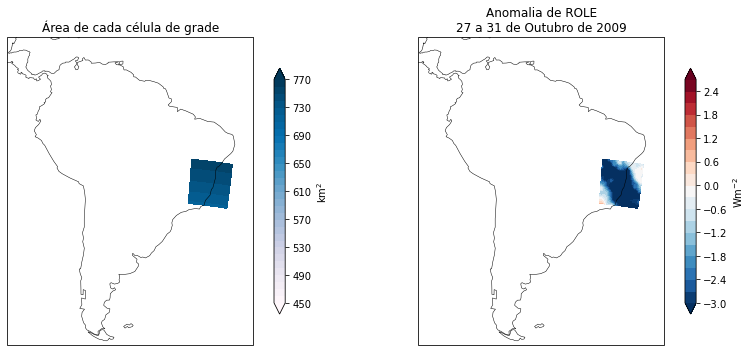

In [227]:
fig=plt.figure(figsize=(12,5))
proj=ccrs.Orthographic(central_longitude=-60, central_latitude=-20, globe=None)

ax = plt.subplot(121, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, area*mask, extend='both', cmap = 'PuBu', transform=ccrs.PlateCarree(), 
             levels=np.arange(450,780,10))
plt.colorbar(orientation='vertical', shrink=0.8, label='km$^2$')
plt.title('Área de cada célula de grade')

ax = plt.subplot(122, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, role_anom*mask, extend='both', cmap = 'RdBu_r', transform=ccrs.PlateCarree(),
             levels=np.arange(-3,3,0.3))
plt.colorbar(orientation='vertical', shrink=0.8, label='Wm$^{-2}$')
plt.title('Anomalia de ROLE\n27 a 31 de Outubro de 2009')

plt.tight_layout()
plt.show()

fig.savefig('AreaRoleMask.png', dpi=300)

### Séries temporais

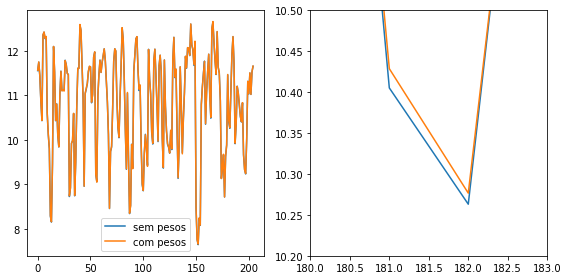

In [255]:
fig=plt.figure(figsize=(8,4))

ax = plt.subplot(121)
plt.plot(rec_role, label='sem pesos')
plt.plot(rec_role_p, label='com pesos')
plt.legend()

ax = plt.subplot(122)
plt.plot(rec_role)
plt.plot(rec_role_p)
plt.xlim((180,183))
plt.ylim((10.2,10.5))

plt.tight_layout()
plt.show()

### Séries Temporais

In [269]:
rec_prec_p = np.nansum(np.nansum(prec*mask*area, axis=1), axis=1)/np.nansum(np.nansum(area*mask))
rec_role_p = np.nansum(np.nansum(role*mask*area, axis=1), axis=1)/np.nansum(np.nansum(area*mask))
rec_w500_p = np.nansum(np.nansum(w500*mask*area, axis=1), axis=1)/np.nansum(np.nansum(area*mask))
rec_mslp_p = np.nansum(np.nansum(mslp*mask*area, axis=1), axis=1)/np.nansum(np.nansum(area*mask))

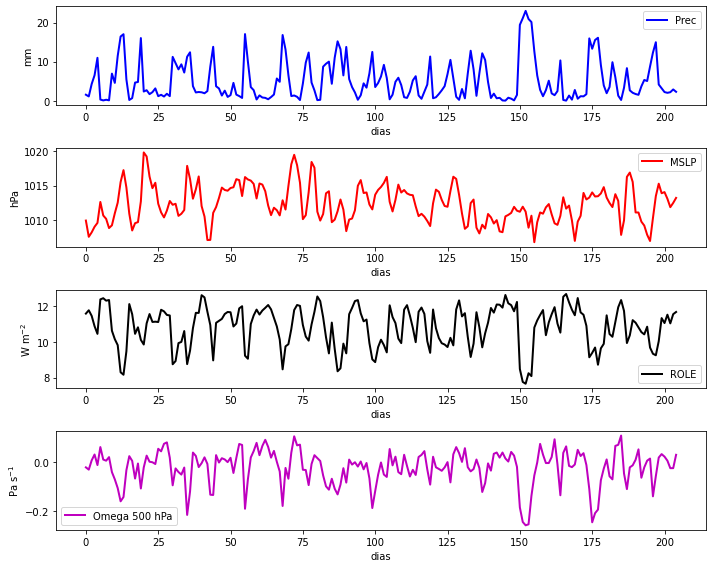

In [342]:
fig=plt.figure(figsize=(10,8))

ax = plt.subplot(411)
plt.plot(rec_prec_p, 'b', lw=2, label='Prec')
plt.ylabel('mm')
plt.xlabel('dias')
plt.legend()

ax = plt.subplot(412)
plt.plot(rec_mslp_p, 'r', lw=2, label='MSLP')
plt.ylabel('hPa')
plt.xlabel('dias')
plt.legend()

ax = plt.subplot(413)
plt.plot(rec_role_p, 'k', lw=2, label='ROLE')
plt.ylabel('W m$^{-2}$')
plt.xlabel('dias')
plt.legend()

ax = plt.subplot(414)
plt.plot(rec_w500_p, 'm', lw=2, label='Omega 500 hPa')
plt.ylabel('Pa s$^{-1}$')
plt.xlabel('dias')
plt.legend()

plt.tight_layout()
plt.show()

fig.savefig('timeSeries_diaria.png', dpi=300)

### Distribuições

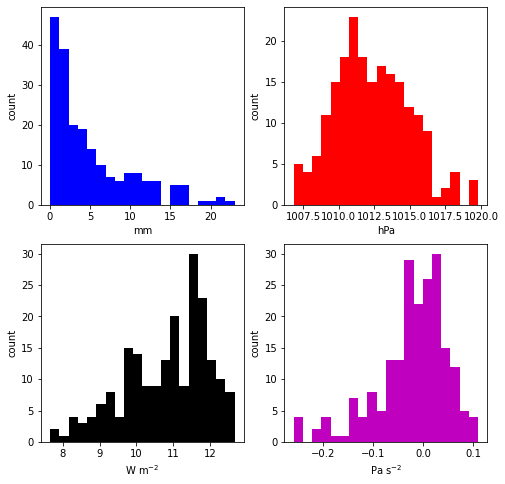

In [296]:
fig=plt.figure(figsize=(8,8))

ax = plt.subplot(221)
plt.hist(rec_prec_p, color='b', bins=20)
plt.ylabel('count'); plt.xlabel('mm')

ax = plt.subplot(222)
plt.hist(rec_mslp_p, color='r', bins=20)
plt.ylabel('count'); plt.xlabel('hPa')

ax = plt.subplot(223)
plt.hist(rec_role_p, color='k', bins=20)
plt.ylabel('count'); plt.xlabel('W m$^{-2}$')

ax = plt.subplot(224)
plt.hist(rec_w500_p, color='m', bins=20)
plt.ylabel('count'); plt.xlabel('Pa s$^{-2}$')

fig.savefig('hist_diaria.png', dpi=300)

### Médias por ano

In [339]:
years = np.arange(time.year[0],time.year[-1]+1)

rec_prec_p_mm = np.zeros(len(years))
rec_mslp_p_mm = np.zeros(len(years))
rec_role_p_mm = np.zeros(len(years))
rec_w500_p_mm = np.zeros(len(years))

for y in np.arange(time.year[0],time.year[-1]+1):
    rec_prec_p_mm[y-1979] = np.mean(rec_prec_p[np.where(time.year==y)[0]])
    rec_mslp_p_mm[y-1979] = np.mean(rec_mslp_p[np.where(time.year==y)[0]])
    rec_role_p_mm[y-1979] = np.mean(rec_role_p[np.where(time.year==y)[0]])
    rec_w500_p_mm[y-1979] = np.mean(rec_w500_p[np.where(time.year==y)[0]])

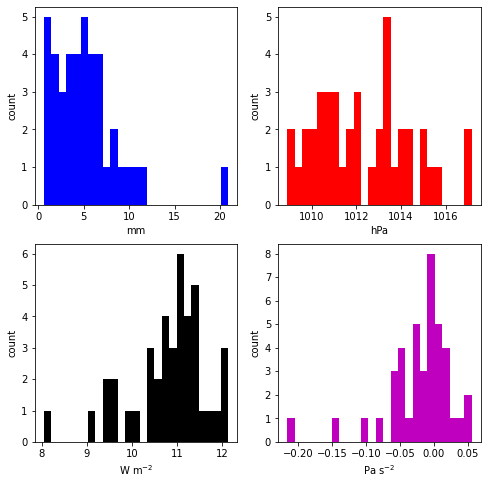

In [341]:
fig=plt.figure(figsize=(8,8))

ax = plt.subplot(221)
plt.hist(rec_prec_p_mm, color='b', bins=25)
plt.ylabel('count'); plt.xlabel('mm')

ax = plt.subplot(222)
plt.hist(rec_mslp_p_mm, color='r', bins=25)
plt.ylabel('count'); plt.xlabel('hPa')

ax = plt.subplot(223)
plt.hist(rec_role_p_mm, color='k', bins=25)
plt.ylabel('count'); plt.xlabel('W m$^{-2}$')

ax = plt.subplot(224)
plt.hist(rec_w500_p_mm, color='m', bins=25)
plt.ylabel('count'); plt.xlabel('Pa s$^{-1}$')

fig.savefig('hist_anual.png', dpi=300)

$$ \mu(x) = \frac{1}{n} \sum_{i=1}^{n} x_i $$

$$ var(x) = \frac{1}{n} \sum_{i=1}^{n} \left( x_i - \mu(x)) \right)^2 $$

$$ \sigma(x) = \sqrt{var(x)}$$

### Correlações

Text(0, 0.5, 'ROLE [W m$^{-2}$]')

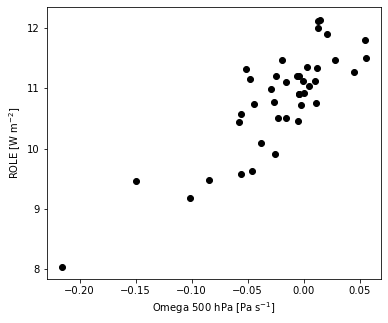

In [350]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.plot(rec_w500_p_mm, rec_role_p_mm, 'ok')
plt.xlabel('Omega 500 hPa [Pa s$^{-1}$]')
plt.ylabel('ROLE [W m$^{-2}$]')

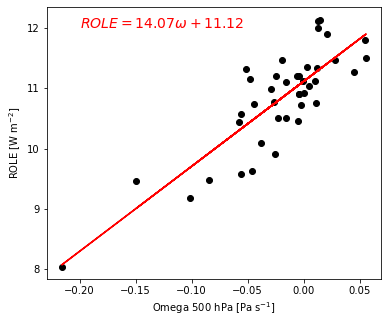

In [381]:
from scipy import stats
model = stats.linregress(rec_w500_p_mm, rec_role_p_mm)
line = rec_w500_p_mm*model.slope + model.intercept

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.plot(rec_w500_p_mm, rec_role_p_mm, 'ok')
plt.plot(rec_w500_p_mm, line, 'r')
plt.xlabel('Omega 500 hPa [Pa s$^{-1}$]')
plt.ylabel('ROLE [W m$^{-2}$]')
plt.text(-0.2,12,'$ROLE=%.2f \omega + %.2f$' %(model.slope, model.intercept), fontsize=14, color='r')

fig.savefig('scatter.png', dpi=300)

### Standardização das Variáveis

In [370]:
rec_w500_p_mm_std = rec_w500_p_mm/np.std(rec_w500_p_mm)
rec_w500_p_mm_std = rec_w500_p_mm_std - np.mean(rec_w500_p_mm_std)
rec_role_p_mm_std = rec_role_p_mm/np.std(rec_role_p_mm) 
rec_role_p_mm_std = rec_role_p_mm_std - np.mean(rec_role_p_mm_std)

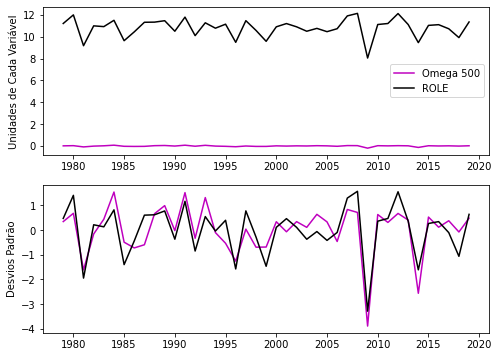

In [382]:
fig=plt.figure(figsize=(8,6))

ax = plt.subplot(211)
plt.plot(years,rec_w500_p_mm, 'm',label='Omega 500')
plt.plot(years,rec_role_p_mm, 'k',label='ROLE')
plt.legend()
plt.ylabel('Unidades de Cada Variável')

ax = plt.subplot(212)
plt.plot(years,rec_w500_p_mm_std, 'm',label='Omega 500')
plt.plot(years,rec_role_p_mm_std, 'k',label='ROLE')
plt.ylabel('Desvios Padrão')

fig.savefig('ts_std.png', dpi=300)

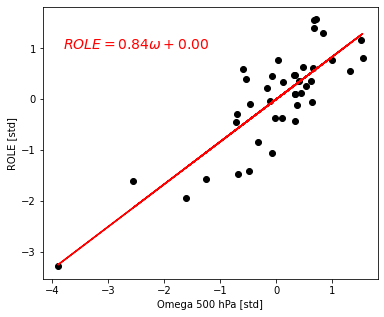

In [383]:
from scipy import stats
model = stats.linregress(rec_w500_p_mm_std, rec_role_p_mm_std)
line = rec_w500_p_mm_std*model.slope + model.intercept

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.plot(rec_w500_p_mm_std, rec_role_p_mm_std, 'ok')
plt.plot(rec_w500_p_mm_std, line, 'r')
plt.xlabel('Omega 500 hPa [std]')
plt.ylabel('ROLE [std]')
plt.text(-3.8,1,'$ROLE=%.2f \omega + %.2f$' %(model.slope, model.intercept), fontsize=14, color='r')

fig.savefig('scatter_std.png', dpi=300)

In [384]:
np.corrcoef(rec_w500_p_mm_std, rec_role_p_mm_std)

array([[1.        , 0.83578333],
       [0.83578333, 1.        ]])

### Mapas de Correlação (ou Regressão)

In [392]:
corr_role_w500 = np.zeros((len(lat), len(lon)))
corr_role_role = np.zeros((len(lat), len(lon)))

for x in range(len(lon)):
    for y in range(len(lat)):
        corr_role_w500[y,x] = np.corrcoef(rec_role_p, w500[:,y,x])[0,1]
        corr_role_role[y,x] = np.corrcoef(rec_role_p, role[:,y,x])[0,1]

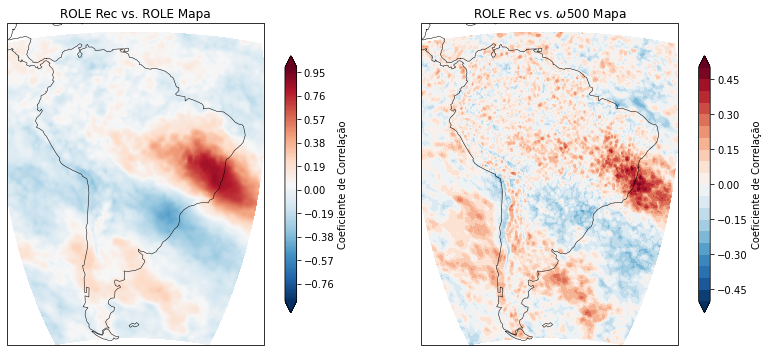

In [396]:
fig=plt.figure(figsize=(12,5))
proj=ccrs.Orthographic(central_longitude=-60, central_latitude=-20, globe=None)

ax = plt.subplot(121, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, corr_role_role, extend='both', cmap = 'RdBu_r', transform=ccrs.PlateCarree(), 
             levels=np.arange(-0.9,1,0.01))
plt.colorbar(orientation='vertical', shrink=0.8, label='Coeficiente de Correlação')
plt.title('ROLE Rec vs. ROLE Mapa')

ax = plt.subplot(122, projection=proj)
ax.set_extent([-90, -30, -55, 20], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
plt.contourf(lon, lat, corr_role_w500, extend='both', cmap = 'RdBu_r', transform=ccrs.PlateCarree(), 
             levels=np.arange(-0.5,0.55,0.05))
plt.colorbar(orientation='vertical', shrink=0.8, label='Coeficiente de Correlação')
plt.title(r'ROLE Rec vs. $\omega$500 Mapa')

plt.tight_layout()
plt.show()

fig.savefig('CorrelMaps.png', dpi=300)